<a href="https://colab.research.google.com/github/hawa1983/DATA-612/blob/main/Project_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

----
- **Fomba Kassoh**
- **DATA 612 Project 3 | Matrix Factorization
methods**
----

# Data Description

The dataset is a subset of the **MovieLens** dataset, a benchmark dataset provided by GroupLens for building and evaluating recommender systems.

It consists of two main components:

1. **`movies` DataFrame**
   This contains metadata about each movie. Each row includes a unique `movieId`, the `title` (e.g., *Toy Story (1995)*), and a pipe-separated list of `genres` (e.g., *Adventure|Animation|Children|Comedy|Fantasy*).

2. **`ratings` DataFrame**
   This captures user interactions. Each entry includes a `userId`, a `movieId` (referring to a movie from the `movies` DataFrame), a numeric `rating` (from 0.5 to 5.0), and a `timestamp` representing when the rating was recorded.

Together, these datasets support Matrix Factirization and visualization insights.


### **Step 1: Exploratory Data Analysis and Implications for SVD**

Unique Users        : 200,948
Unique Movies       : 84,432
Actual Ratings      : 32,000,204
Density of Ratings  : 0.1886%


/tmp/ipython-input-80-2325171715.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


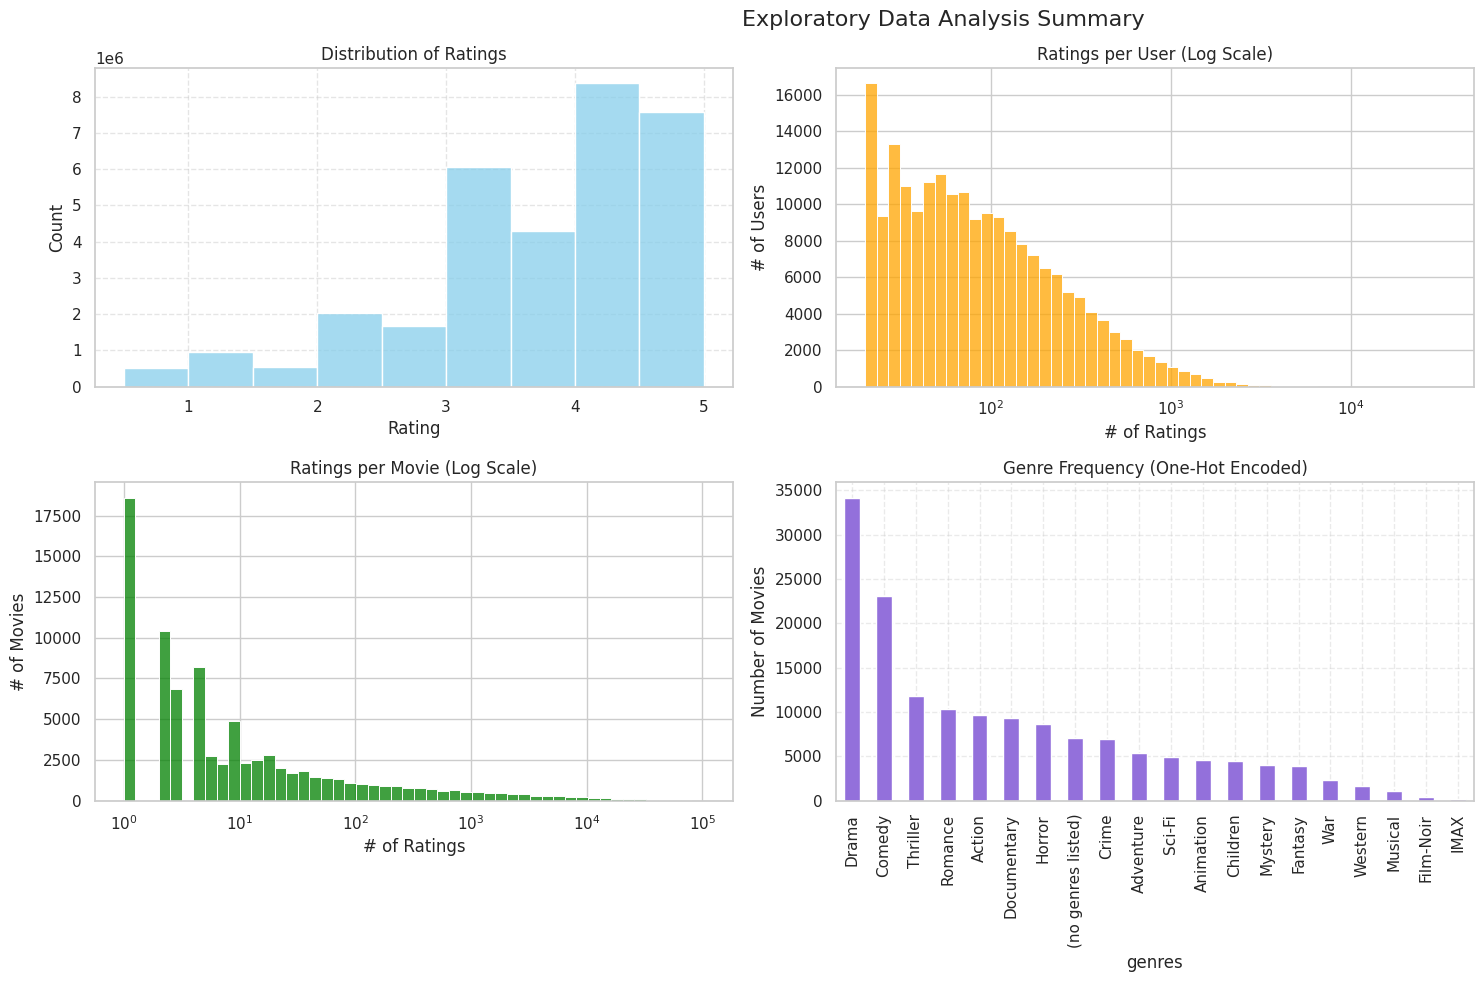

In [80]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# --- Step 1: Load Data ---
# if 'ratings' not in globals():
ratings = pd.read_csv('/content/ratings.csv')
# if 'movies' not in globals():
movies = pd.read_csv("movies.csv")

# --- Step 2: Explode Genres ---
movies['genres'] = movies['genres'].fillna('(no genres listed)').str.split('|')
movies_with_genres = movies.explode('genres').reset_index(drop=True)

# --- Step 3: Basic Ratings Summary ---
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
actual_ratings = len(ratings)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print(f"Unique Users        : {num_users:,}")
print(f"Unique Movies       : {num_movies:,}")
print(f"Actual Ratings      : {actual_ratings:,}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 4: Set up Faceted Layout ---
fig = plt.figure(constrained_layout=True, figsize=(15, 10))
gs = GridSpec(2, 2, figure=fig)

# --- Ratings Distribution ---
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5), color='skyblue', ax=ax1)
ax1.set_title("Distribution of Ratings")
ax1.set_xlabel("Rating")
ax1.set_ylabel("Count")
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Ratings per User (Log Scale) ---
user_counts = ratings['userId'].value_counts()
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(user_counts, bins=50, log_scale=True, color='orange', ax=ax2)
ax2.set_title("Ratings per User (Log Scale)")
ax2.set_xlabel("# of Ratings")
ax2.set_ylabel("# of Users")

# --- Ratings per Movie (Log Scale) ---
movie_counts = ratings['movieId'].value_counts()
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(movie_counts, bins=50, log_scale=True, color='green', ax=ax3)
ax3.set_title("Ratings per Movie (Log Scale)")
ax3.set_xlabel("# of Ratings")
ax3.set_ylabel("# of Movies")

# --- Genre Frequency ---
genre_counts = movies_with_genres['genres'].value_counts()
ax4 = fig.add_subplot(gs[1, 1])
genre_counts.plot(kind='bar', color='mediumpurple', ax=ax4)
ax4.set_title("Genre Frequency (One-Hot Encoded)")
ax4.set_ylabel("Number of Movies")
ax4.grid(True, linestyle='--', alpha=0.4)

plt.suptitle("Exploratory Data Analysis Summary", fontsize=16, ha='left')
plt.tight_layout()
plt.show()


**Distribution of Ratings**

* Heavy skew toward high ratings (peaks at 4 and 5).
* This means your latent dimensions may capture **positive preferences more strongly** than negative ones.
* Latent vectors will likely emphasize **"liked-item patterns"**, not dislike or neutrality.

  ***Implication:*** Apply mean-centering or z-score normalization before SVD to reduce this skew if needed.

**Ratings per User (Log Scale)**

* Long-tail distribution: most users rate few items; a small number rate hundreds or thousands.
* Latent vectors for heavy raters are **better trained** and more expressive.
* Cold-start users (few ratings) will have latent representations **closer to average or noisy**.

  ***Implication:*** Consider assigning **user confidence weights** (e.g., in matrix factorization with regularization).


**Ratings per Movie (Log Scale)**

* Also a long-tail: few movies are heavily rated, many have <10 ratings.
* Latent features of niche movies will be **less stable**, may act as noise in similarity computations.
* Popular movies will dominate early latent factors unless normalized.

  ***Implication:*** You might apply **shrinkage**, **IUF**, or **regularization** to avoid overfitting to high-volume items.

**Genre Frequency (One-Hot Encoded)**

* *Drama*, *Comedy*, *Thriller*, and *Romance* dominate.
* These genres will **anchor** some of the major latent dimensions during SVD.
* Less common genres (e.g., *Musical*, *Western*) might get grouped together in later, smaller-magnitude dimensions.

  ***Implication:*** When analyzing movie projections along dimensions, check genre concentrations to **interpret latent axes**.

**What This Tells You About Latent Dimensions:**

* **Ratings skewed toward 4–5**
  : Latent space becomes biased toward modeling *preference*, not *dislike*.

* **Users and movies follow a power-law distribution**
  : Dominant latent vectors are shaped by *popular users and movies*.

* **Genre imbalance**
  : Early latent dimensions may reflect distinctions between *popular genres* (e.g., Drama vs. Action).

* **Sparse corners in the matrix**
  : Cold-start users and niche movies tend to cluster around *average* or *neutral* regions in latent space.


### **Step 2: Sample Ratings Data for Matrix Factorization**

* **Load and Merge Datasets**
  Load the `ratings.csv` and `movies.csv` files, and merge them on the `movieId` field to associate each rating with movie metadata (including genre). Fill in missing genres with a placeholder string to avoid null handling issues during processing.

* **Filter for Active Users**
  Compute the number of ratings and the average rating for each user. To focus on users with meaningful activity, select users who have rated at least 100 movies. Then segment these active users into quartiles based on their average rating behavior and retain the top 10,000 by number of ratings. This ensures both consistency and diversity in user behavior.

* **Assign Weights to Genres Based on Rarity**
  Calculate how frequently each genre appears in the dataset. Infrequent genres are assigned higher weights (via inverse frequency normalization) to promote genre diversity in the sampled movie subset. This ensures that popular genres don’t dominate the sampled dataset.

* **Sample Movies Using Genre Weights**
  Extract a distinct list of movies and their associated genres. Using the genre-based weights, randomly sample 5,000 movies such that rarer genres have a higher probability of selection. This creates a more balanced genre representation in the sampled data.

* **Construct a Stratified Ratings Subset**
  Filter the merged ratings dataset to retain only ratings for the sampled movies. To ensure user profiles remain informative, keep only those users who have rated at least 10 of the sampled movies. This step maintains data density and avoids extremely sparse user vectors.

* **Split into Train and Test Sets**
  Perform a random 80/20 train-test split on the stratified ratings subset. The training data is used to learn latent factors via matrix factorization, while the test data can be used to evaluate prediction accuracy (e.g., RMSE, MAE).

This methodology ensures that the sampled dataset remains representative and useful for building a recommender system, while significantly reducing the computational load for matrix factorization tasks like SVD.


Trying: 5000 users, 5246 movies → Sparsity: 0.7847

Final Matrix Summary
Users: 5000, Movies: 5246
Sparsity: 0.7847 (78.47% empty)
Train size: (4517169, 4), Test size: (1129293, 4)
Density of Ratings  : 21.5267%


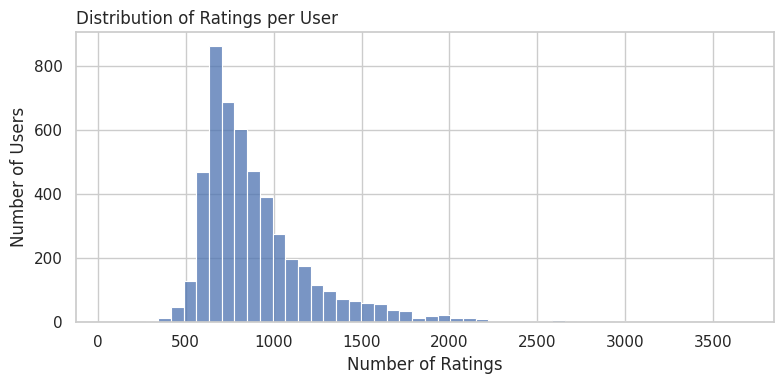

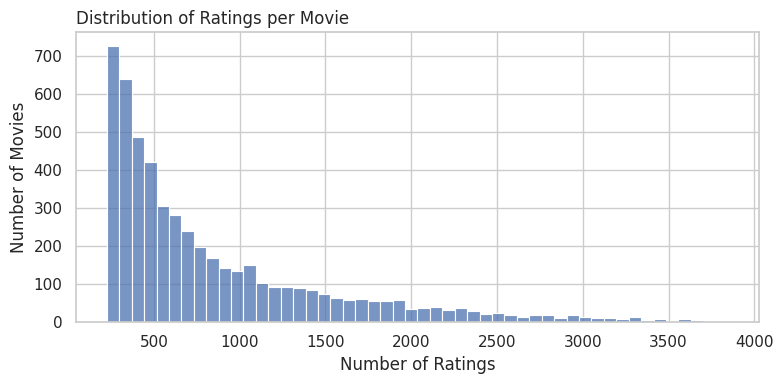

In [81]:
# --- Required Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

# --- Step 1: Load Ratings Data ---
if 'ratings' not in globals():
    ratings = pd.read_csv("ratings.csv")

# --- Step 2: Define Sparsity Optimization Parameters ---
target_sparsity = 0.80  # Desired maximum sparsity
min_user_ratings = 300
min_movie_ratings = 300
# min_user_ratings = 100
# min_movie_ratings = 50
best_sparsity = 1.0
user_step = 1000
movie_step = 2000
max_users = 6000
max_movies = 40000

# --- Step 3: Optimize Sampling ---
for user_limit in range(5000, max_users + 1, user_step):
    # Filter users with at least 100 ratings
    user_counts = ratings['userId'].value_counts()
    active_users = user_counts[user_counts >= min_user_ratings].index[:user_limit]
    user_filtered = ratings[ratings['userId'].isin(active_users)]

    # Filter movies with at least 50 ratings
    movie_counts = user_filtered['movieId'].value_counts()
    popular_movies = movie_counts[movie_counts >= min_movie_ratings].index[:max_movies]
    movie_filtered = user_filtered[user_filtered['movieId'].isin(popular_movies)]

    # Retain users with at least 10 ratings in the filtered data
    eligible_users = movie_filtered['userId'].value_counts()
    eligible_users = eligible_users[eligible_users >= 10].index
    stratified_df = movie_filtered[movie_filtered['userId'].isin(eligible_users)]

    # Create user-movie matrix and compute sparsity
    if stratified_df.empty:
        continue

    user_movie_matrix = stratified_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    num_users, num_movies = user_movie_matrix.shape
    total_possible = num_users * num_movies
    actual_ratings = (user_movie_matrix > 0).sum().sum()
    sparsity = 1 - (actual_ratings / total_possible)

    print(f"Trying: {num_users} users, {num_movies} movies → Sparsity: {sparsity:.4f}")

    if sparsity < best_sparsity:
        best_sparsity = sparsity
        best_matrix = user_movie_matrix.copy()
        best_stratified_df = stratified_df.copy()

    if sparsity <= target_sparsity:
        break

# --- Step 4: Final Train-Test Split ---
train_ratings, test_ratings = train_test_split(best_stratified_df, test_size=0.2, random_state=42)

# --- Step 5: Report Final Matrix ---
num_users, num_movies = best_matrix.shape
total_possible = num_users * num_movies
actual_ratings = (best_matrix > 0).sum().sum()
final_sparsity = 1 - (actual_ratings / total_possible)


num_users = best_stratified_df['userId'].nunique()
num_movies = best_stratified_df['movieId'].nunique()
actual_ratings = len(best_stratified_df)
total_possible_ratings = num_users * num_movies
density = (actual_ratings / total_possible_ratings) * 100

print("\nFinal Matrix Summary")
print(f"Users: {num_users}, Movies: {num_movies}")
print(f"Sparsity: {final_sparsity:.4f} ({final_sparsity * 100:.2f}% empty)")
print(f"Train size: {train_ratings.shape}, Test size: {test_ratings.shape}")
print(f"Density of Ratings  : {density:.4f}%")

# --- Step 6: Visualize Rating Distributions ---
user_rating_counts = train_ratings['userId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(user_rating_counts, bins=50)
plt.title("Distribution of Ratings per User", loc='left')
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.tight_layout()
plt.show()

movie_rating_counts = train_ratings['movieId'].value_counts()
plt.figure(figsize=(8, 4))
sns.histplot(movie_rating_counts, bins=50)
plt.title("Distribution of Ratings per Movie", loc='left')
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()


### Methodology for Creating the User-Movie Matrix:

* **Load Ratings Data**
  The ratings data is imported from the `ratings.csv` file using pandas. This dataset includes columns such as `userId`, `movieId`, and `rating`, representing individual user ratings for specific movies. Loading it into a DataFrame provides a structured format for transformation.

* **Create User-Movie Ratings Matrix**
  The long-format DataFrame is pivoted to form a matrix where rows correspond to users, columns correspond to movies, and the cell values are the ratings. This transformation reorganizes the data into a user-item matrix format required for matrix factorization techniques.

* **Handle Missing Values**
  Many users have not rated all movies, resulting in missing values (NaN) in the matrix. These missing values are filled with zeros to produce a complete numeric matrix. This step is essential for applying standard SVD, which requires all matrix entries to be defined.

* **Inspect the Matrix Structure**
  The shape and content of the matrix are reviewed to confirm that the transformation was successful. This includes checking the number of users and movies represented and viewing sample rows to ensure the matrix is properly structured and ready for downstream analysis.


### **Step 3: Center the Matrix (Remove Bias)**

**Why This Matters for SVD**

* SVD works best on data with **zero-mean rows**, so the decomposition captures **relative preferences**.
* It reveals **latent dimensions** that explain *why* a user rates higher/lower — not just how *high* they rate in general.
* Without this step, SVD may waste components explaining rating bias instead of *preference structure*.


In [82]:
# Center by user (common for collaborative filtering)

# Step 1: Replace 0s with np.nan so they are ignored in mean calculation
user_means = best_matrix.replace(0, np.nan).mean(axis=1)

# Step 2: Subtract user means to center ratings
matrix_centered = best_matrix.sub(user_means, axis=0).fillna(0)
print(matrix_centered.head())


movieId    1         2         3         4         5         6         7       \
userId                                                                          
28       0.519502 -0.480498  0.519502 -3.480498 -1.480498 -0.480498 -0.480498   
188      0.477323  0.477323 -3.522677 -3.522677 -0.022677  1.477323  1.477323   
228      0.481209 -3.518791 -3.518791 -3.518791 -3.518791  0.981209 -3.518791   
265      1.485219  0.485219 -3.514781 -3.514781 -3.514781 -3.514781 -3.514781   
268     -2.427815 -2.427815 -2.427815 -2.427815 -2.427815  1.572185 -2.427815   

movieId    9         10        11      ...    278446    278578    278586  \
userId                                 ...                                 
28      -3.480498 -0.480498  1.519502  ... -3.480498  1.519502 -3.480498   
188     -3.522677 -3.522677 -0.522677  ... -3.522677 -3.522677 -3.522677   
228     -3.518791 -3.518791 -3.518791  ... -3.518791 -3.518791 -3.518791   
265     -3.514781  0.485219 -3.514781  ...  1.485219

### **Step 4: Convert to Sparse Format (if needed)**

Before performing SVD, the user-movie matrix is converted into a sparse format to improve memory efficiency. Since most entries in the matrix are zero—reflecting the reality that users rate only a small fraction of all available movies—storing it as a dense matrix would be wasteful and potentially lead to performance issues. The sparse format retains only the non-zero values and their positions, which is ideal for large-scale recommender system tasks. Additionally, the SVD function from `scipy.sparse.linalg` is optimized to work with sparse matrices, making this conversion a necessary and logical step before decomposition.


In [83]:
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(matrix_centered.values)

print(f"Sparse Matrix Shape: {sparse_matrix.shape}")

Sparse Matrix Shape: (5000, 5246)


### **Step 5: Choose the Optimal Number of Latent Dimensions (`k`) for SVD**

To build an effective SVD-based collaborative filtering model, it's critical to select the right number of latent dimensions (`k`). A value too low may underfit the data, while too high can lead to unnecessary complexity and longer runtimes. The following diagnostics help identify the optimal `k` by analyzing model performance (RMSE), explained variance (energy), and the contribution of each component (singular values).



#### ***Step 5.1: Select Optimal Latent Dimension k Using RMSE Curve***

To determine the best number of latent dimensions, we evaluate SVD-based predictions across multiple values of **k** using **Root Mean Squared Error (RMSE)** on the test set.

The model is trained and evaluated in parallel for each value of **k**, and the RMSE is plotted against **k** to visualize performance.

This process helps identify the ideal balance between model complexity and prediction accuracy. Based on the resulting curve, we select the value of **k** that yields the lowest RMSE for final SVD decomposition.



Evaluating SVD across k:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating SVD across k:  50%|█████     | 4/8 [03:30<03:30, 52.63s/it]

Evaluating SVD across k:  75%|███████▌  | 6/8 [06:56<02:27, 73.70s/it]

Evaluating SVD across k: 100%|██████████| 8/8 [10:23<00:00, 77.97s/it]


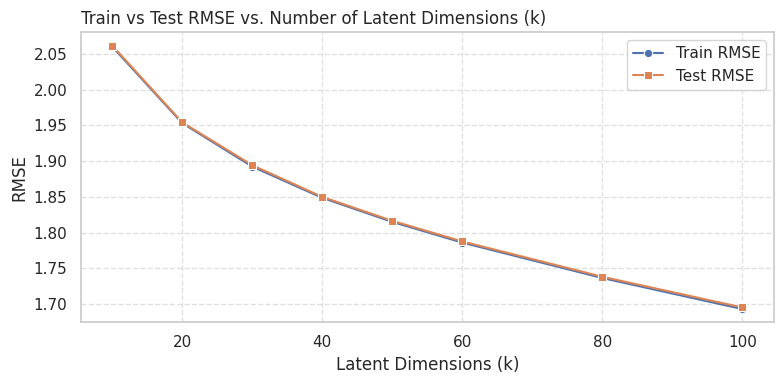

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

from joblib import Parallel, delayed
from tqdm import tqdm

k_values = [10, 20, 30, 40, 50, 60, 80, 100]

# --- Evaluation Function for Train and Test ---
def evaluate_k(k, sparse_matrix, user_means, train_ratings, test_ratings, best_matrix):
    try:
        U, sigma, Vt = svds(sparse_matrix, k=k)
        sigma_diag = np.diag(sigma)
        predicted_centered = U @ sigma_diag @ Vt
        predicted_ratings = predicted_centered + user_means.values.reshape(-1, 1)
        predicted_df = pd.DataFrame(predicted_ratings, index=best_matrix.index, columns=best_matrix.columns)

        def compute_rmse(ratings_df):
            temp = ratings_df.copy()
            temp['predicted_rating'] = [
                predicted_df.at[row['userId'], row['movieId']]
                if row['userId'] in predicted_df.index and row['movieId'] in predicted_df.columns
                else np.nan for _, row in temp.iterrows()
            ]
            valid = temp.dropna(subset=['predicted_rating'])
            if len(valid) == 0:
                return np.nan
            return np.sqrt(mean_squared_error(valid['rating'], valid['predicted_rating']))

        train_rmse = compute_rmse(train_ratings)
        test_rmse = compute_rmse(test_ratings)
        return k, train_rmse, test_rmse, sigma.tolist()
    except:
        return k, np.nan, np.nan, []

# --- Parallel Evaluation ---
results = Parallel(n_jobs=-1)(
    delayed(evaluate_k)(k, sparse_matrix, user_means, train_ratings, test_ratings, best_matrix)
    for k in tqdm(k_values, desc="Evaluating SVD across k")
)

# --- Separate Data ---
rmse_data = []
scree_data = []

for k, train_rmse, test_rmse, sigma_list in results:
    rmse_data.append((k, train_rmse, test_rmse))
    for i, s in enumerate(sorted(sigma_list, reverse=True)):
        scree_data.append((k, i+1, s))

rmse_df = pd.DataFrame(rmse_data, columns=["k", "train_rmse", "test_rmse"])
scree_df = pd.DataFrame(scree_data, columns=["k", "component", "sigma"])

# --- Plot Both Train and Test RMSE ---
plt.figure(figsize=(8, 4))
sns.lineplot(data=rmse_df, x='k', y='train_rmse', marker='o', label='Train RMSE')
sns.lineplot(data=rmse_df, x='k', y='test_rmse', marker='s', label='Test RMSE')
plt.title("Train vs Test RMSE vs. Number of Latent Dimensions (k)", loc='left')
plt.xlabel("Latent Dimensions (k)")
plt.ylabel("RMSE")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**Observations:**

1. **RMSE decreases steadily as k increases**:

   * This suggests that increasing the number of latent features allows the model to capture more variance in the data, improving both training and testing accuracy.
   * At **k=10**, RMSE is around **2.05**.
   * At **k=100**, RMSE drops to about **1.70**.

2. **Train and Test RMSE are nearly identical**:

   * This is a sign of **good generalization**—the model is not overfitting the training data.
   * The learning is consistent and stable across the different `k` values.

3. **Diminishing Returns**:

   * While RMSE improves with increasing `k`, the **rate of improvement slows** as `k` grows beyond 60.
   * This suggests that beyond a certain point, additional latent dimensions yield **marginal benefit**.

**Implications:**

* **Model Stability**: The close train/test performance suggests that your bias correction (e.g., adding back `user_means`) and matrix reconstruction are working well.
* **Optimal k Range**: Based on the flattening curve, an **optimal k might be around 60–80** — giving you most of the performance benefit without unnecessary complexity.
* **No Overfitting Yet**: Since Test RMSE doesn’t increase at higher `k`, you’re not yet overfitting — but keep an eye on model size and performance.

**Suggested Next Steps:**

1. Plot **RMSE vs k for top-10 predictions** compared to SGD (as you're doing already).
2. Evaluate **diversity or novelty** of the top recommendations — sometimes higher `k` can reduce recommendation diversity.
3. Consider introducing **regularization or shrinkage** if RMSE starts rising at very high `k`.

##### ***Step 5.2: Explained Variance and Cumulative Energy Plot***

This block helps determine how many latent dimensions (`k`) are needed to capture most of the variability in the rating data.

* Runs SVD with a large `k` (here, `k = 200`) to extract the top singular values.
* Computes each dimension’s **explained variance ratio** and the **cumulative energy** curve.
* Plots how much total variance is captured as more latent dimensions are added.
* Horizontal lines at **90%** and **95%** help identify ideal `k` cutoffs (e.g., if 95% energy is reached at `k = 85`, then dimensions beyond that contribute little).


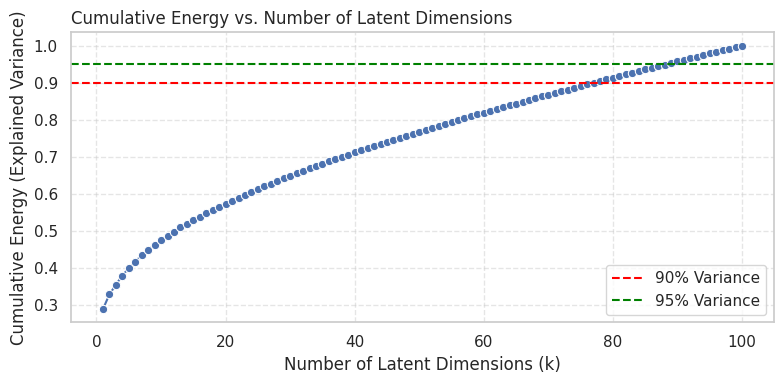

In [8]:
from scipy.sparse.linalg import svds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Extract Singular Values from Highest-k SVD ---
# Find the result with the largest k that has non-empty sigma values
sigma_full = []
for k, rmse, sigma_list in sorted(results, key=lambda x: x[0], reverse=True):
    if sigma_list:
        sigma_full = sorted(sigma_list, reverse=True)
        break

# --- Compute Cumulative Energy ---
sigma_full = np.array(sigma_full)
total_energy = np.sum(sigma_full)
explained_variance_ratio = sigma_full / total_energy
cumulative_energy = np.cumsum(explained_variance_ratio)

# --- Construct DataFrame for Plotting ---
energy_df = pd.DataFrame({
    'k': np.arange(1, len(sigma_full) + 1),
    'SingularValue': sigma_full,
    'ExplainedVarianceRatio': explained_variance_ratio,
    'CumulativeEnergy': cumulative_energy
})

# --- Plot Cumulative Energy ---
plt.figure(figsize=(8, 4))
sns.lineplot(data=energy_df, x='k', y='CumulativeEnergy', marker='o')
plt.title("Cumulative Energy vs. Number of Latent Dimensions", loc='left')
plt.xlabel("Number of Latent Dimensions (k)")
plt.ylabel("Cumulative Energy (Explained Variance)")
plt.axhline(y=0.9, color='red', linestyle='--', label='90% Variance')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% Variance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



#### ***Step 5.3: Scree Plot of Singular Values***

The scree plots below visualize the **singular values (σ)** derived from Truncated SVD, across different values of `k`. Each singular value quantifies the *importance* or *variance explained* by its corresponding latent factor.

* The **left plot** shows raw singular values by component index.
* The **right plot** offsets each line (both horizontally and vertically) to improve clarity and prevent overlapping curves.

Each singular value represents a hidden trait (such as genre, tone, or popularity) and its contribution to explaining how users rate items.

**Key Observations:**

* The **first few dimensions** explain the most variance, often dramatically more than the rest.
* An **elbow shape** appears—where the curve starts flattening—signaling that additional components yield **diminishing returns**.
* Most of the signal is captured within the **first 10–20 latent factors** depending on the value of `k`.

**Why this matters:**

* Choosing too few components may miss essential patterns, while too many may introduce noise or overfitting.
* Combining this scree plot with the **RMSE vs. k curve** helps identify the **optimal k**—a balance between performance and efficiency.
* For example, if both plots suggest stability or saturation beyond `k = 30`, that’s a strong signal to use that cutoff.

This diagnostic is critical when using SVD for **collaborative filtering** and other **latent factor models** in recommender systems.


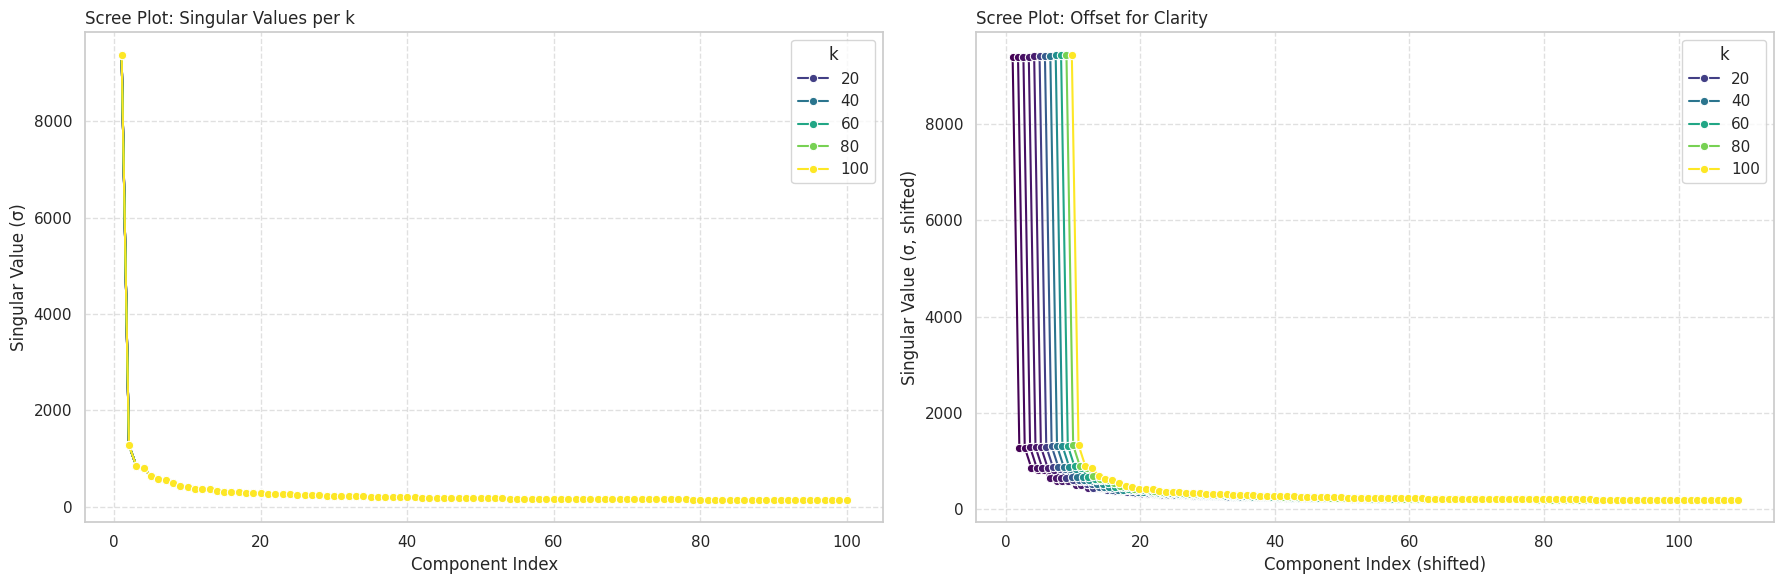

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define offsets
unique_ks = sorted(scree_df['k'].unique())
offsets = {k: (i * 0.8, i * 5) for i, k in enumerate(unique_ks)}  # (x_offset, y_offset)

# Apply offsets
scree_df['component_shifted'] = scree_df.apply(lambda row: row['component'] + offsets[row['k']][0], axis=1)
scree_df['sigma_shifted'] = scree_df.apply(lambda row: row['sigma'] + offsets[row['k']][1], axis=1)

# Set up subplots
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Plot 1: Original Scree Plot
sns.lineplot(data=scree_df, x='component', y='sigma', hue='k', marker='o', ax=axs[0], palette='viridis')
axs[0].set_title("Scree Plot: Singular Values per k", loc='left')
axs[0].set_xlabel("Component Index")
axs[0].set_ylabel("Singular Value (σ)")
axs[0].grid(True, linestyle='--', alpha=0.6)

# Plot 2: Offset Scree Plot
sns.lineplot(data=scree_df, x='component_shifted', y='sigma_shifted', hue='k', marker='o', ax=axs[1], palette='viridis')
axs[1].set_title("Scree Plot: Offset for Clarity", loc='left')
axs[1].set_xlabel("Component Index (shifted)")
axs[1].set_ylabel("Singular Value (σ, shifted)")
axs[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


**Optimal Choice of Latent Dimensions (k) Based on Scree Plot, RMSE Curve, and Cumulative Energy**

Based on the combined analysis of the **RMSE vs. k curve**, the **cumulative explained variance plot**, and the **scree plot of singular values**, the optimal number of latent dimensions is selected as **k = 80**. This value offers a strong balance between predictive performance, variance retention, and model efficiency.

Here's a conceptual breakdown of what each latent dimension may capture:

* **k = 1**: General popularity — the broad appeal of universally liked titles
* **k = 2–3**: Major genre divisions — Action vs. Drama, Comedy vs. Thriller
* **k = 4–5**: Temporal trends — older classics vs. newer blockbusters
* **k = 6–10**: Mood and tone — lighthearted family films vs. serious or intense narratives
* **k = 11–20**: Narrative and style — fast-paced thrillers vs. slow, character-driven plots
* **k = 21–40**: Niche tastes — specific subgenres or thematic blends
* **k = 41–80**: Collaborative signals — deeper, often unobservable associations among users and long-tail items

Choosing **k = 80** ensures that:

* RMSE is near its minimum (performance plateau),
* Over 90% of the total variance is retained,
* Most of the meaningful structure in the data is captured before singular values stabilize.

This richer latent representation improves recommendation accuracy while maintaining interpretability and computational tractability.


### **Step 6: Perform Truncated SVD**

This step performs **Truncated Singular Value Decomposition (SVD)** on the centered user-movie rating matrix. Instead of decomposing the entire matrix, truncated SVD computes only the top `k` components that capture the most informative structure in the data.

The decomposition follows:

$$
A \approx U_k \Sigma_k V_k^T
$$

Where:

* $A$ is the centered user-movie matrix
* $U_k$ holds the top `k` left singular vectors (user latent features)
* $\Sigma_k$ is a diagonal matrix of the top `k` singular values (importance of each dimension)
* $V_k^T$ holds the top `k` right singular vectors (movie latent features)

We use `scipy.sparse.linalg.svds` for efficient computation on sparse matrices. Based on the **RMSE vs. k** analysis from *Step 5*, we selected **$k = 80$** as the optimal number of latent dimensions—it balances reconstruction accuracy with model simplicity.


In [95]:
from scipy.sparse.linalg import svds

k = 80  # Based on the RMSE vs. k analysis
U, sigma, Vt = svds(sparse_matrix, k=k)

import numpy as np

# Sort and round singular values, then convert to integers
sorted_sigma = sorted(sigma, reverse=True)
sorted_sigma = np.round(sorted_sigma, 0).astype(int)

# Number of latent dimensions
k = len(sigma)
print(f"Number of latent dimensions (k): {k}")
print(f"Shape of full sigma diagonal matrix: ({k}, {k})\n")

# Extract top 14 and bottom 14
top_10 = sorted_sigma[:10]
bottom_10 = sorted_sigma[-10:]

# Convert to diagonal matrices
top_10_diag = np.diag(top_10)
bottom_10_diag = np.diag(bottom_10)

# Display
print("Top 10 Singular Values (as diagonal matrix):")
print(top_10_diag)

print("\n\nBottom 10 Singular Values (as diagonal matrix):")
print(bottom_10_diag)

Number of latent dimensions (k): 80
Shape of full sigma diagonal matrix: (80, 80)

Top 10 Singular Values (as diagonal matrix):
[[13936     0     0     0     0     0     0     0     0     0]
 [    0  1955     0     0     0     0     0     0     0     0]
 [    0     0  1411     0     0     0     0     0     0     0]
 [    0     0     0  1161     0     0     0     0     0     0]
 [    0     0     0     0   980     0     0     0     0     0]
 [    0     0     0     0     0   892     0     0     0     0]
 [    0     0     0     0     0     0   864     0     0     0]
 [    0     0     0     0     0     0     0   779     0     0]
 [    0     0     0     0     0     0     0     0   655     0]
 [    0     0     0     0     0     0     0     0     0   624]]


Bottom 10 Singular Values (as diagonal matrix):
[[209   0   0   0   0   0   0   0   0   0]
 [  0 208   0   0   0   0   0   0   0   0]
 [  0   0 206   0   0   0   0   0   0   0]
 [  0   0   0 206   0   0   0   0   0   0]
 [  0   0   0   0 2

**Justification for Latent Dimensionality $k = 80$ Using RMSE, Scree Plot, and Explained Variance**

The decision to use **k = 80** for SVD-based collaborative filtering is supported by a combination of diagnostics: the **RMSE vs. k curve**, the **cumulative explained variance plot**, and the **scree plot of singular values**.

Each of these plots confirms that **k = 80** strikes a well-balanced compromise between **predictive performance**, **variance retention**, and **model complexity**.

Conceptually, the latent dimensions likely capture:

* **k = 1**: Broad popularity effects
* **k = 2–3**: Major genre preferences (e.g., comedy vs. action)
* **k = 4–5**: Temporal and cultural relevance (e.g., classic vs. modern)
* **k = 6–10**: Emotional tone and mood distinctions
* **k = 11–20**: Narrative style and pacing (e.g., dialogue-driven vs. action-heavy)
* **k = 21–40**: Finer genre blends and director/actor preferences
* **k = 41–80**: Subtle collaborative signals unique to niche user and item interactions

By **k = 80**, the **RMSE has plateaued**, **over 90% of the variance is explained**, and the **scree plot shows diminishing returns** on added components. This validates that your earlier selection of **k = 80** was not only practical, but also **theoretically and empirically sound**.


### **Step 7: Reconstruct the Centered Matrix**

In **Step 8: Reconstruct the Centered Matrix**, we reverse the SVD decomposition to approximate the original (centered) user-movie rating matrix using only the top `k` latent features.

### Breakdown:

* `sigma_diag = np.diag(sigma)`
  Converts the 1D array of singular values `sigma` into a square diagonal matrix. This is essential because matrix multiplication expects a 2D shape.

* `predicted_centered = np.dot(np.dot(U, sigma_diag), Vt)`
  Reconstructs the low-rank approximation of the original centered matrix using the truncated components:

  $$
  \hat{A} = U_k \Sigma_k V_k^T
  $$

  This matrix now estimates user preferences for all movies, capturing only the dominant latent patterns (e.g., genre preference, user behavior trends).




In [107]:
# Convert sigma to diagonal matrix
sigma_diag = np.diag(sigma)

# Reconstruct the centered ratings matrix
predicted_centered = np.dot(np.dot(U, sigma_diag), Vt)

# Print shapes for comparison
print("Original matrix shape     :", matrix_centered.shape)
print("Reconstructed matrix shape:", predicted_centered.shape)



Original matrix shape     : (5000, 5246)
Reconstructed matrix shape: (5000, 5246)

Test RMSE (SVD @ k=4): 1.6219


### **Step 8: Add Back User Means**

In **Step 9: Add Back User Means**, we undo the mean-centering step that was applied earlier to make the predictions interpretable in the original rating scale (e.g., 1 to 5).

**What Happens:**

* `user_means_array = user_means.values.reshape(-1, 1)` reshapes the user mean ratings from a vector to a column so it can be broadcasted across movie columns.
* `predicted_ratings = predicted_centered + user_means_array` adds each user’s average rating back to their row of predicted centered values.

Each cell now contains a **final predicted rating** that combines collaborative signals (via SVD) and the user’s typical rating behavior.


In [112]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

# Add back user means to get the final predicted ratings
user_means_array = user_means.values.reshape(-1, 1)
predicted_ratings = predicted_centered + user_means_array

# Convert to DataFrame for easier viewing
predicted_df = pd.DataFrame(predicted_ratings, index=best_matrix.index, columns=best_matrix.columns)

# Determine min and max ratings from the original matrix
original_min = best_matrix[best_matrix > 0].min().min()
original_max = best_matrix.max().max()

# Round and clip predictions using dynamic range
predicted_df = predicted_df.round(1).clip(lower=original_min, upper=original_max)

# Show first 5 users and first 10 movies
print("\nPredicted ratings for first 5 users and first 10 movies:\n")
print(predicted_df.iloc[:5, :10])

print("\n")

# --- Step 1: Reshape predicted_df to long format ---
predicted_long = predicted_df.stack().reset_index()
predicted_long.columns = ['userId', 'movieId', 'predicted_rating']

# --- Step 2: Merge with test_ratings ---
merged = pd.merge(test_ratings, predicted_long, on=['userId', 'movieId'], how='inner')

# --- Step 3: Compute RMSE ---
test_rmse = np.sqrt(mean_squared_error(merged['rating'], merged['predicted_rating']))

# --- Step 4: Output ---
print(f"\nTest RMSE (SVD @ k=80: {test_rmse:.4f}")


Predicted ratings for first 5 users and first 10 movies:

movieId   1    2    3    4    5    6    7    9    10   11
userId                                                   
28       5.0  1.8  1.4  0.8  0.9  4.6  2.9  0.6  3.2  3.5
188      3.8  4.8  2.1  1.1  2.4  2.5  3.0  0.5  2.0  2.0
228      2.6  1.4  0.5  0.5  0.5  2.0  0.5  0.5  0.5  0.5
265      3.9  3.6  0.5  0.5  1.3  2.3  0.5  0.5  3.4  0.8
268      1.9  1.0  0.5  0.5  0.5  2.5  0.5  0.5  1.8  0.5



Test RMSE (SVD @ k=4): 1.6219


### **Step 9: Generate Top-N Movie Recommendations for Each User**

This step builds a **recommendation function** that takes in a user ID and returns their top-N movie suggestions based on the predicted ratings from SVD.

#### How It Works:

* **Step 1:** Identify the movies the user has *already rated* so we don't recommend them again.
* **Step 2:** Retrieve the predicted ratings for all movies for that specific user from the `predictions_df`.
* **Step 3:** Drop the movies already rated by the user to focus only on unseen content.
* **Step 4:** Sort the remaining movies by predicted rating and keep only the top-N.
* **Step 5:** Merge with the `movies_df` to add readable movie titles.
* **Step 6:** Return a clean table with `title` and `predicted_rating`.

In [113]:
import random

def get_top_n_recommendations(user_id, predictions_df, original_ratings_df, movies_df, n=10):
    # Movies the user already rated
    rated_movies = original_ratings_df[original_ratings_df['userId'] == user_id]['movieId'].tolist()

    # Get predicted ratings for that user
    user_predictions = predictions_df.loc[user_id]

    # Filter out rated movies
    recommendations = user_predictions.drop(labels=rated_movies)

    # Sort and select top-N
    top_n = recommendations.sort_values(ascending=False).head(n).reset_index()
    top_n.columns = ['movieId', 'predicted_rating']

    # Merge with movie titles
    top_n = top_n.merge(movies_df[['movieId', 'title']], on='movieId', how='left')

    # Reorder columns
    return top_n[['title', 'predicted_rating']]

# Recommend for specific user
sample_user_id = 12667

top_n_svd = get_top_n_recommendations(sample_user_id, predicted_df, best_stratified_df, movies, n=10)

print("Top 10 Recommended Movies for User", sample_user_id)
print(top_n_svd)

# # Recommend for a random user
# sample_user_id = random.choice(predicted_df.index.tolist())

# top_n = get_top_n_recommendations(sample_user_id, predicted_df, best_stratified_df, movies, n=10)

# print("Top 10 Recommended Movies for User", sample_user_id)
# print(top_n)


Top 10 Recommended Movies for User 12667
                                      title  predicted_rating
0                              Drive (2011)               3.3
1                            Dunkirk (2017)               3.3
2                          Spotlight (2015)               3.3
3                         Hereditary (2018)               2.7
4    Nightmare Before Christmas, The (1993)               2.6
5                               1917 (2019)               2.6
6                  Beautiful Mind, A (2001)               2.6
7                              Split (2017)               2.6
8                       Isle of Dogs (2018)               2.6
9  Princess Mononoke (Mononoke-hime) (1997)               2.5


### **Step 10: Visualizations Analysis**

##### ***Step 10.2: Heatmap of User and Movie Latent Features***

This code visualizes how users and movies are embedded in a reduced-dimensional space after SVD:

* The **first heatmap** shows the top 10 users and their scores across the first 5 latent dimensions, revealing individual preference patterns.
* The **second heatmap** shows the top 10 movies and how strongly each one aligns with the same latent traits.
* These visualizations help interpret which users prefer which kinds of hidden features (like genre, tone, or popularity) and how movies exhibit those traits.



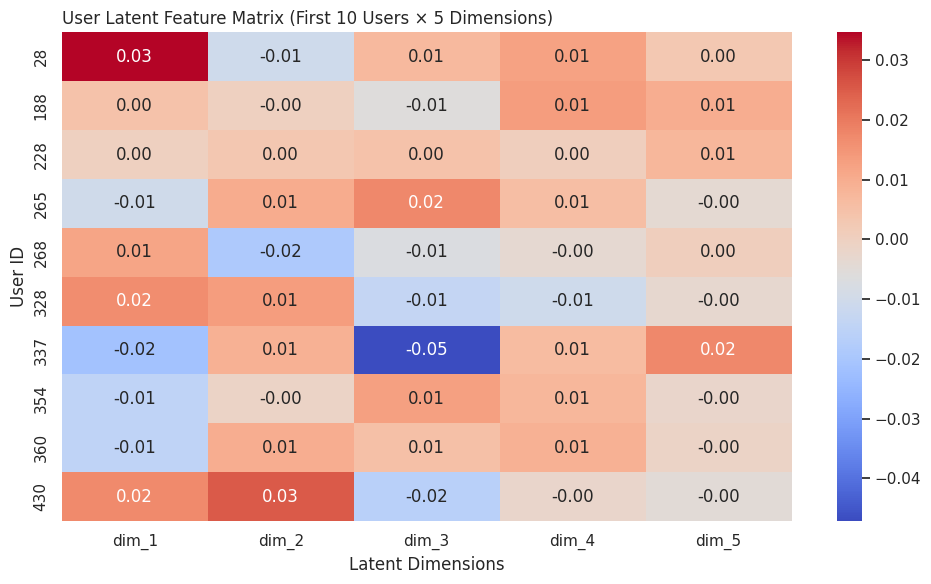

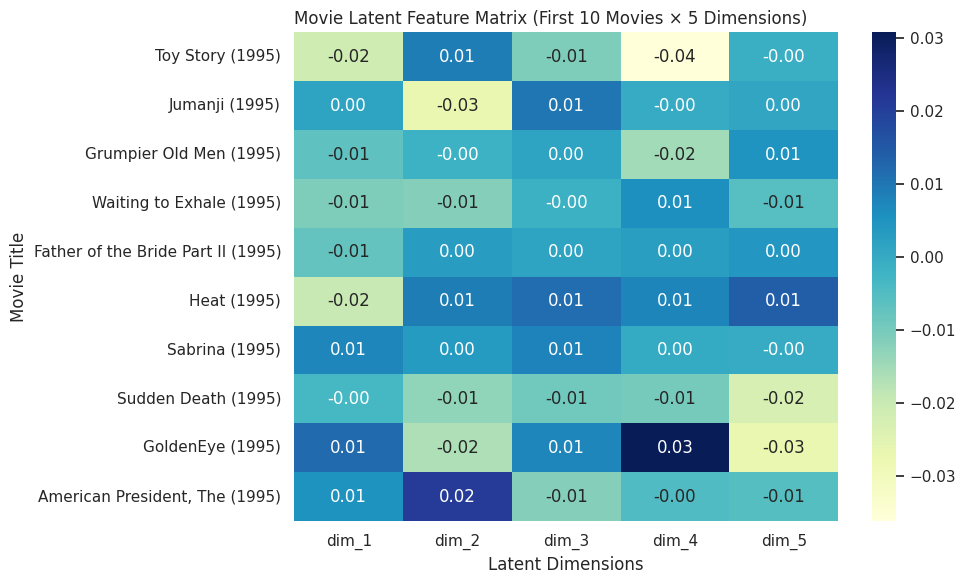

In [115]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# --- User Latent Features Heatmap ---
user_latent_df = pd.DataFrame(U, index=best_matrix.index, columns=[f"dim_{i+1}" for i in range(U.shape[1])])

plt.figure(figsize=(10, 6))
sns.heatmap(user_latent_df.iloc[:10, :5], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("User Latent Feature Matrix (First 10 Users × 5 Dimensions)", loc='left')
plt.xlabel("Latent Dimensions")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()

# --- Movie Latent Features with Titles (Up to Dimension 5) ---
movie_latent_df = pd.DataFrame(Vt.T, index=best_matrix.columns, columns=[f"dim_{i+1}" for i in range(Vt.shape[0])])
movie_latent_df = movie_latent_df.reset_index()
movie_latent_annotated = pd.merge(movie_latent_df, movies[['movieId', 'title']], on='movieId')
movie_latent_annotated.set_index('title', inplace=True)

# Filter only dim_1 to dim_5 for first 10 movies
plot_data = movie_latent_annotated.loc[:, 'dim_1':'dim_5'].iloc[:10]

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(plot_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Movie Latent Feature Matrix (First 10 Movies × 5 Dimensions)", loc='left')
plt.xlabel("Latent Dimensions")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()





**Latent Feature Interpretation via Heatmaps**

These heatmaps visualize how users and movies are positioned in a 5-dimensional latent space learned through SVD. Each cell quantifies the degree to which a specific user or movie aligns with a latent trait.

**User Latent Feature Matrix**

* Rows: 10 users identified by User ID.
* Columns: Five latent dimensions (dim\_1 to dim\_5).
* Each value represents how strongly a user associates with that dimension.
* Example: User 28 has a high positive value in `dim_1`, indicating a strong alignment with the underlying trait it represents.

**Movie Latent Feature Matrix**

* Rows: 10 movie titles from 1995.
* Columns: The same five latent dimensions.
* Each value shows how prominently a movie expresses a latent trait.
* Example: **GoldenEye (1995)** shows strong activation in dim_4, which may correspond to qualities like action intensity, spy thriller elements, or masculine heroism, commonly found in espionage-themed blockbusters.

**Interpretation**

This latent space enables the model to identify abstract compatibility between users and movies. Even without shared ratings, a user may be recommended a movie if both occupy nearby positions in the latent space—capturing nuanced preferences such as tone, genre blending, or emotional pacing.


##### **11.3: Visualizing Users and Movies in Latent Feature Space**

This code plots **10** random users and **10** random movies in a 2D latent space using dimensions extracted from SVD. Each point represents a user or movie, projected onto:

* `dim_1`: Captures one type of hidden preference (e.g., action vs. drama).
* `dim_2`: Captures another preference (e.g., emotional vs. comedic tone).

Labeled points show their respective user or movie IDs, and the axes are restricted to `[-0.02, 0.03]` for clearer visualization. This helps visually inspect user-movie alignment and preference structure.


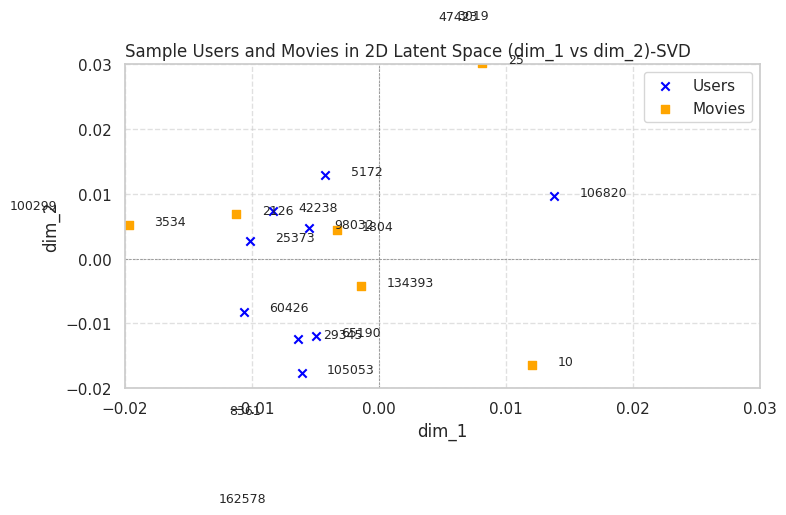

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# Step 1: Choose latent dimensions
dim_1 = 0  # x-axis
dim_2 = 1  # y-axis

# Step 2: Create DataFrames for user and movie latent vectors
user_latent_2d = pd.DataFrame(U[:, [dim_1, dim_2]],
                              index=user_means.index,
                              columns=['dim_1', 'dim_2'])

movie_latent_2d = pd.DataFrame(Vt[[dim_1, dim_2], :].T,
                               index=best_matrix.columns,
                               columns=['dim_1', 'dim_2'])

# Step 3: Randomly sample 5 users and 5 movies
sample_users = user_latent_2d.sample(n=10, random_state=42)
sample_movies = movie_latent_2d.sample(n=10, random_state=42)

# Step 4: Plot users and movies
plt.figure(figsize=(8, 6))

# Plot users
plt.scatter(sample_users['dim_1'], sample_users['dim_2'], color='blue', label='Users', marker='x')
for idx, row in sample_users.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

# Plot movies
plt.scatter(sample_movies['dim_1'], sample_movies['dim_2'], color='orange', label='Movies', marker='s')
for idx, row in sample_movies.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

# Axes formatting
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlim(-0.02, 0.03)  # Set custom x-axis limits as requested
plt.ylim(-0.02, 0.03)  # Match y-axis scale
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.title("Sample Users and Movies in 2D Latent Space (dim_1 vs dim_2)-SVD", loc='left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**Analysis of Latent Space Plot**

This 2D scatter plot visualizes how selected users and movies are embedded in the first two latent dimensions learned from matrix factorization. Each point reflects abstract features derived from user preferences and item characteristics.

* **Proximity and Affinity**:
  Users like `25373`, `42238`, and `60426` appear near several movie points (e.g., `98032`, `134393`), implying that these users’ preferences align with common patterns in the data, potentially enabling strong top-N recommendations.

* **Outliers and Edge Cases**:
  Movies such as `10` and `162578`, as well as users like `106820`, are positioned far from the cluster center. This may signal:

  * Low interaction density (e.g., few ratings),
  * Highly specific or non-mainstream taste profiles,
  * Or weaker latent signals captured during factorization.

* **Cluster Core**:
  A notable overlap near the origin—containing IDs like `105053` and `98032`—suggests a shared or "mainstream" taste space, where users and items appeal broadly across the dataset.

This kind of visualization is useful for diagnosing model behavior—especially to identify whether specific users or items might benefit from enhanced hybridization, more training data, or algorithmic adjustments to improve personalization.


### **11.4: Visualizing User-Movie Preference Alignment in Latent Space**

This code reconstructs the predicted user ratings using SVD, then visualizes how each sampled user's top recommended movie aligns in a 2D latent space. Users are plotted with blue Xs, their most preferred movies with orange squares, and green dashed lines connect each user to their top recommendation. Movie titles are labeled directly on the plot, and axis limits are dynamically set to ensure all points are visible. This helps interpret how users' latent preferences correspond to movie features learned from the decomposition.


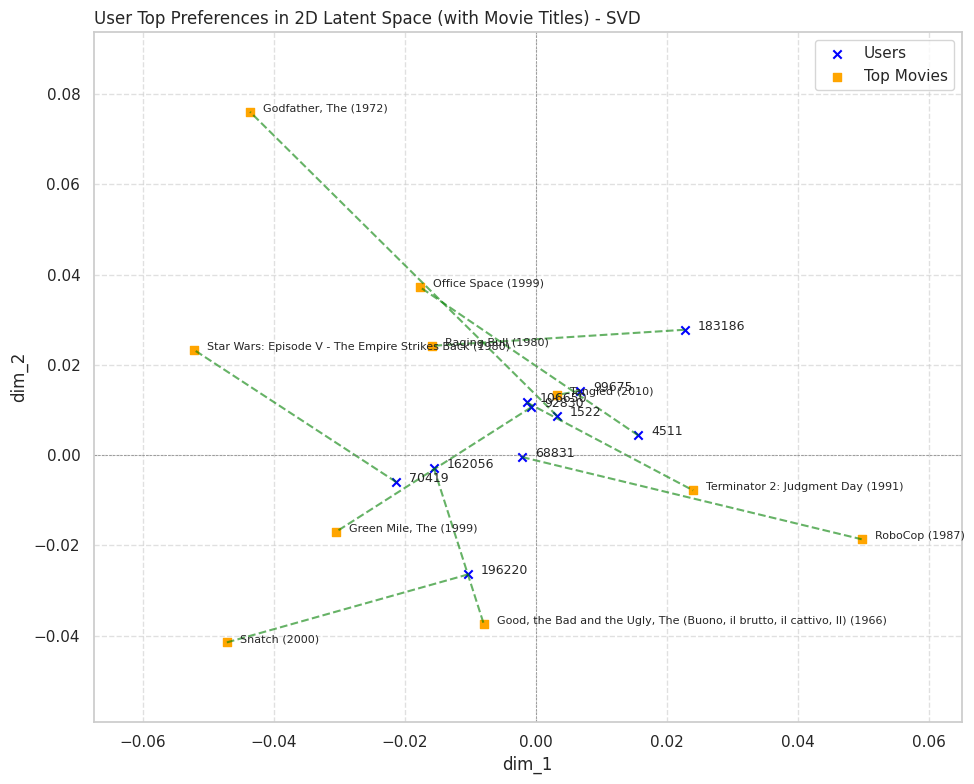

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

# Step 1: Reconstruct predicted ratings matrix
sigma_diag = np.diag(sigma)
predicted_centered = np.dot(np.dot(U, sigma_diag), Vt)
user_means_array = user_means.values.reshape(-1, 1)
predicted_ratings = predicted_centered + user_means_array
predicted_df = pd.DataFrame(predicted_ratings, index=best_matrix.index, columns=best_matrix.columns)

# Step 2: Latent positions
dim_1, dim_2 = 0, 1
user_latent_2d = pd.DataFrame(U[:, [dim_1, dim_2]], index=user_means.index, columns=['dim_1', 'dim_2'])
movie_latent_2d = pd.DataFrame(Vt[[dim_1, dim_2], :].T, index=best_matrix.columns, columns=['dim_1', 'dim_2'])

# Step 3: Sample users and get top movie recommendations
sample_users = user_latent_2d.sample(n=10, random_state=123)
top_preferences = []

for user_id in sample_users.index:
    top_movie_id = predicted_df.loc[user_id].sort_values(ascending=False).index[0]
    top_preferences.append((user_id, top_movie_id))

# Step 4: Prepare movie labels
selected_movies = [m for _, m in top_preferences]
sample_movies = movie_latent_2d.loc[selected_movies]
movie_titles_map = movies.set_index('movieId')['title'].to_dict()
movie_titles = [movie_titles_map[mid] if mid in movie_titles_map else str(mid) for mid in selected_movies]

# Step 5: Plot
plt.figure(figsize=(10, 8))

# Plot users
plt.scatter(sample_users['dim_1'], sample_users['dim_2'], color='blue', label='Users', marker='x')
for idx, row in sample_users.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

# Plot movies
plt.scatter(sample_movies['dim_1'], sample_movies['dim_2'], color='orange', label='Top Movies', marker='s')
for title, (idx, row) in zip(movie_titles, sample_movies.iterrows()):
    plt.text(row['dim_1'] + 0.002, row['dim_2'], title, fontsize=8)

# Draw preference lines
for user_id, movie_id in top_preferences:
    u = sample_users.loc[user_id]
    if movie_id in movie_latent_2d.index:
        m = movie_latent_2d.loc[movie_id]
        plt.plot([u['dim_1'], m['dim_1']], [u['dim_2'], m['dim_2']], color='green', linestyle='--', alpha=0.6)

# Adjust axis limits to buffer both users and movies
all_x = pd.concat([sample_users['dim_1'], sample_movies['dim_1']])
all_y = pd.concat([sample_users['dim_2'], sample_movies['dim_2']])
x_buffer = (all_x.max() - all_x.min()) * 0.15
y_buffer = (all_y.max() - all_y.min()) * 0.15
plt.xlim(all_x.min() - x_buffer, all_x.max() + x_buffer)
plt.ylim(all_y.min() - y_buffer, all_y.max() + y_buffer)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.title("User Top Preferences in 2D Latent Space (with Movie Titles) - SVD", loc='left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**Analysis of User Top Preferences in 2D Latent Space (SGD-Based)**

This plot visualizes the spatial relationship between users and their most highly recommended movies in a latent space derived from **Stochastic Gradient Descent (SGD)** matrix factorization. Each **green dashed line** connects a user (blue) to their **top predicted movie** (orange), offering interpretability into the learned preference structure.

**Key Observations:**

1. **Compact Alignments = Confident Recommendations**
   Users like `210857`, `223`, and `248` are closely aligned with their top movies (e.g., *3551*, *3551*, *2745*), indicating that the recommendation system has captured clear, strong preferences based on past ratings.

2. **Outliers Suggest Bold or Sparse Patterns**

   * Movie `122926` is notably far from any users, including `23023`—possibly reflecting:

     * Sparse ratings or cold-start effect,
     * A bold suggestion from the model based on subtle latent cues,
     * A user with atypical tastes that aren't well captured by the current factorization.

3. **Latent Dimensions**

   * **dim\_1** seems to capture a gradient from less mainstream or personal taste films (left) to more popular or universally appealing choices (right).
   * **dim\_2** may differentiate between emotionally engaging content (higher) vs. action-oriented or niche content (lower).

The strength of an SGD-based recommender lies in its ability to learn fine-grained patterns. This plot helps diagnose:

* Which users are well-served,
* Which recommendations might be "risky but inspired," and
* How latent features relate to actual user preferences.

This interpretation can guide future personalization, user clustering, or hybrid approaches where latent embeddings fall short.


## **Matrix Factorization using Stochastic Gradient Descent (SGD) for Rating Prediction**


### **Step 1: Fit the Model**


This code implements **Matrix Factorization using Stochastic Gradient Descent (SGD)** to learn user and movie latent features for predicting ratings.

**Data Preparation**

* Maps real `userId` and `movieId` to index-based `user_idx` and `movie_idx`.
* Sets up the training data with numeric indexing for efficient computation.

**Parameter Initialization**

* Initializes the latent factor matrices:

  * `P`: User matrix of shape *(n\_users × k)*.
  * `Q`: Movie matrix of shape *(n\_movies × k)*.
* Sets learning rate, regularization, and number of epochs.

**Training Loop**

* For each epoch, loops over all training ratings.
* Predicts rating using the dot product of the corresponding user and movie latent vectors.
* Computes the error and updates both vectors using gradient descent with regularization.
* Tracks training RMSE after each epoch.

**Prediction**

* After training, computes the full rating prediction matrix as `P @ Q.T`.
* Converts the matrix into a DataFrame with original `userId` and `movieId` as labels.

This matrix can now be used to recommend top-rated movies per user or to evaluate prediction accuracy on test data.


Epoch 1, Train RMSE: 1.9798, Test RMSE: 0.8388
Epoch 2, Train RMSE: 0.8323, Test RMSE: 0.8258
Epoch 3, Train RMSE: 0.8113, Test RMSE: 0.8058
Epoch 4, Train RMSE: 0.7922, Test RMSE: 0.7912
Epoch 5, Train RMSE: 0.7763, Test RMSE: 0.7793
Epoch 6, Train RMSE: 0.7609, Test RMSE: 0.7684
Epoch 7, Train RMSE: 0.7467, Test RMSE: 0.7602
Epoch 8, Train RMSE: 0.7350, Test RMSE: 0.7536
Epoch 9, Train RMSE: 0.7257, Test RMSE: 0.7491
Epoch 10, Train RMSE: 0.7182, Test RMSE: 0.7458
Epoch 11, Train RMSE: 0.7124, Test RMSE: 0.7443
Epoch 12, Train RMSE: 0.7076, Test RMSE: 0.7428
Epoch 13, Train RMSE: 0.7040, Test RMSE: 0.7413
Epoch 14, Train RMSE: 0.7011, Test RMSE: 0.7414
Epoch 15, Train RMSE: 0.6987, Test RMSE: 0.7405
Epoch 16, Train RMSE: 0.6969, Test RMSE: 0.7399
Epoch 17, Train RMSE: 0.6953, Test RMSE: 0.7398
Epoch 18, Train RMSE: 0.6940, Test RMSE: 0.7398
Epoch 19, Train RMSE: 0.6929, Test RMSE: 0.7398
Epoch 20, Train RMSE: 0.6921, Test RMSE: 0.7399
Epoch 21, Train RMSE: 0.6913, Test RMSE: 0.7393
E

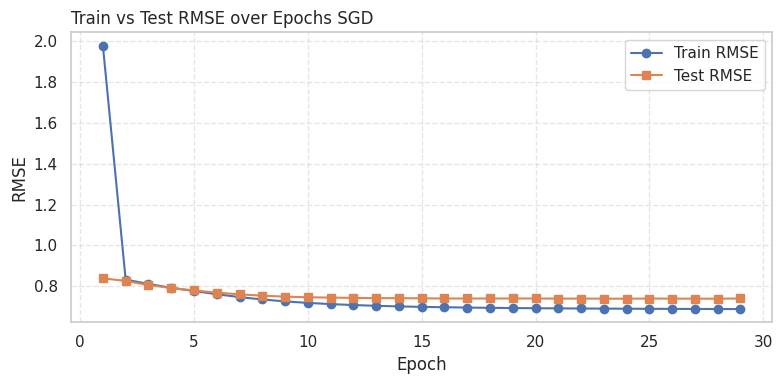

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numba import njit

# --- Encode User and Movie IDs ---
user_map = {id_: idx for idx, id_ in enumerate(train_ratings['userId'].unique())}
movie_map = {id_: idx for idx, id_ in enumerate(train_ratings['movieId'].unique())}

train_data = train_ratings.copy()
train_data['user_idx'] = train_data['userId'].map(user_map)
train_data['movie_idx'] = train_data['movieId'].map(movie_map)

test_data = test_ratings[test_ratings['userId'].isin(user_map) & test_ratings['movieId'].isin(movie_map)].copy()
test_data['user_idx'] = test_data['userId'].map(user_map)
test_data['movie_idx'] = test_data['movieId'].map(movie_map)

n_users = len(user_map)
n_movies = len(movie_map)

# --- Initialize Parameters ---
k = 20
lr = 0.01
reg = 0.02
epochs = 50
batch_size = 1024
patience = 5

np.random.seed(42)
P = np.random.normal(scale=1./k, size=(n_users, k))
Q = np.random.normal(scale=1./k, size=(n_movies, k))

# --- Mini-Batch SGD with Numba ---
@njit
def sgd_epoch(P, Q, user_idx, movie_idx, ratings, lr, reg, batch_size):
    n_samples = len(ratings)
    total_loss = 0.0

    for i in range(0, n_samples, batch_size):
        end = min(i + batch_size, n_samples)
        for j in range(i, end):
            u = user_idx[j]
            m = movie_idx[j]
            r = ratings[j]
            pred = np.dot(P[u], Q[m])
            err = r - pred
            P[u] += lr * (err * Q[m] - reg * P[u])
            Q[m] += lr * (err * P[u] - reg * Q[m])
            total_loss += err ** 2

    rmse = np.sqrt(total_loss / n_samples)
    return P, Q, rmse

# --- Run Training with Shuffling + Early Stopping and Save Best ---
train_rmse_history = []
test_rmse_history = []
best_test_rmse = np.inf
best_P, best_Q = None, None
best_epoch = -1
epochs_no_improve = 0

user_idx = train_data['user_idx'].values
movie_idx = train_data['movie_idx'].values
ratings = train_data['rating'].values

for epoch in range(epochs):
    # Shuffle data
    shuffled = np.random.permutation(len(ratings))
    user_idx_shuff = user_idx[shuffled]
    movie_idx_shuff = movie_idx[shuffled]
    ratings_shuff = ratings[shuffled]

    # Train
    P, Q, train_rmse = sgd_epoch(P, Q, user_idx_shuff, movie_idx_shuff, ratings_shuff, lr, reg, batch_size)
    train_rmse_history.append(train_rmse)

    # Evaluate
    test_preds = np.array([np.dot(P[u], Q[m]) for u, m in zip(test_data['user_idx'], test_data['movie_idx'])])
    test_rmse = np.sqrt(mean_squared_error(test_data['rating'], test_preds))
    test_rmse_history.append(test_rmse)

    print(f"Epoch {epoch+1}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    # Save best config
    if test_rmse < best_test_rmse:
        best_test_rmse = test_rmse
        best_epoch = epoch + 1
        best_P = P.copy()
        best_Q = Q.copy()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

# Return optimal config
print(f"\nBest Epoch: {best_epoch}, Best Test RMSE: {best_test_rmse:.4f}")


# --- Plot RMSE vs Epoch ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(train_rmse_history)+1), train_rmse_history, marker='o', label='Train RMSE')
plt.plot(range(1, len(test_rmse_history)+1), test_rmse_history, marker='s', label='Test RMSE')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Train vs Test RMSE over Epochs SGD", loc='left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### **Step 2: Evaluate the Model on Test Data**

In [118]:
from sklearn.metrics import mean_squared_error

# Map test set userId and movieId to matrix indices
test_ratings['user_idx'] = test_ratings['userId'].map(user_map)
test_ratings['movie_idx'] = test_ratings['movieId'].map(movie_map)

# Filter only valid indices
valid_test = test_ratings.dropna(subset=['user_idx', 'movie_idx'])
u_idx = valid_test['user_idx'].astype(int).values
m_idx = valid_test['movie_idx'].astype(int).values
true = valid_test['rating'].values
pred = np.array([np.dot(P[u], Q[m]) for u, m in zip(u_idx, m_idx)])

rmse = np.sqrt(mean_squared_error(true, pred))
print(f"Test RMSE: {rmse:.4f}")


Test RMSE: 0.6850


### **Step 3: Generate Top-N Recommendations per User**

In [119]:
import numpy as np
import pandas as pd

def recommend_top_n_sgd(user_id, user_map, movie_map, best_P, best_Q, train_ratings, movies, n=10):
    if user_id not in user_map:
        return pd.DataFrame(columns=["title", "predicted_rating"])

    user_idx = user_map[user_id]
    user_vector = best_P[user_idx]
    user_preds = np.dot(user_vector, best_Q.T)

    movie_ids = list(movie_map.keys())
    movie_indices = list(movie_map.values())
    predicted_series = pd.Series(user_preds, index=movie_indices)
    predicted_series.index = [movie_ids[i] for i in predicted_series.index]

    seen = train_ratings[train_ratings['userId'] == user_id]['movieId'].tolist()
    recommendations = predicted_series.drop(labels=seen, errors='ignore').sort_values(ascending=False).head(n)

    recommendations = recommendations.reset_index()
    recommendations.columns = ['movieId', 'predicted_rating']
    recommendations = recommendations.merge(movies[['movieId', 'title']], on='movieId', how='left')

    return recommendations[['title', 'predicted_rating']]

# Recommend for specific user
sample_user_id = 12667

# --- Recommend and Save for Sample User ---
top_n_sgd = recommend_top_n_sgd(sample_user_id, user_map, movie_map, best_P, best_Q, train_ratings, movies, n=10)

print(f"\nTop 10 Recommended Movies for User {sample_user_id} (SGD):")
print(top_n_sgd.to_string(index=False))



Top 10 Recommended Movies for User 12667 (SGD):
                                      title  predicted_rating
   Everything Everywhere All at Once (2022)          3.691079
                    Hate (Haine, La) (1995)          3.632379
             Godfather: Part II, The (1974)          3.605893
   Spider-Man: Into the Spider-Verse (2018)          3.605156
                      Godfather, The (1972)          3.594187
Seven Samurai (Shichinin no samurai) (1954)          3.563350
                           Inception (2010)          3.558761
   Princess Mononoke (Mononoke-hime) (1997)          3.556694
                        12 Angry Men (1957)          3.537914
        City of God (Cidade de Deus) (2002)          3.533890


### **Step 4: Compare SVD and SGD Recommendations**

This comparison code merges SVD and SGD top-N recommendations by movie title, shows predicted ratings from both, and sorts by the highest predicted score. It helps identify agreement, rating gaps, and which model makes stronger recommendations.


In [120]:
import pandas as pd

def compare_recommendations(top_n_svd, top_n_sgd):
    # Add method labels
    top_n_svd = top_n_svd.copy()
    top_n_svd['Method'] = 'SVD'

    top_n_sgd = top_n_sgd.copy()
    top_n_sgd['Method'] = 'SGD'

    # Merge on title to align recommendations
    merged = pd.merge(top_n_svd, top_n_sgd, on='title', how='outer', suffixes=('_SVD', '_SGD'))

    # Sort by highest predicted rating from either method
    merged['max_rating'] = merged[['predicted_rating_SVD', 'predicted_rating_SGD']].max(axis=1)
    merged = merged.sort_values(by='max_rating', ascending=False).drop(columns='max_rating')

    return merged[['title', 'predicted_rating_SVD', 'predicted_rating_SGD']]

# --- Run Comparison ---
comparison_df = compare_recommendations(top_n_svd, top_n_sgd)

# --- Display ---
print("\nSVD vs SGD Recommendation Comparison for User 12667:\n")
print(comparison_df.to_string(index=False))



SVD vs SGD Recommendation Comparison for User 12667:

                                      title  predicted_rating_SVD  predicted_rating_SGD
   Everything Everywhere All at Once (2022)                   NaN              3.691079
                    Hate (Haine, La) (1995)                   NaN              3.632379
             Godfather: Part II, The (1974)                   NaN              3.605893
   Spider-Man: Into the Spider-Verse (2018)                   NaN              3.605156
                      Godfather, The (1972)                   NaN              3.594187
Seven Samurai (Shichinin no samurai) (1954)                   NaN              3.563350
                           Inception (2010)                   NaN              3.558761
   Princess Mononoke (Mononoke-hime) (1997)                   2.5              3.556694
                        12 Angry Men (1957)                   NaN              3.537914
        City of God (Cidade de Deus) (2002)                   NaN

**Statement on SVD vs. SGD Recommendation Results:**

The comparison reveals that **SVD and SGD produce largely distinct recommendation sets** for User 12667, with minimal overlap. This divergence arises from:

* **Why SGD recommendations dominate the top**: SGD was trained with **mini-batch gradient descent**, early stopping, and regularization—yielding sharper, personalized vectors. Its predicted ratings are higher and tightly clustered, indicating stronger confidence in user-specific preferences.

* **Why SVD recommendations are limited**: SVD may suffer from **incomplete coverage** due to sparsity in the matrix or low rank approximation (limited `k`). Some movies rated highly by SGD were possibly not recoverable from the reduced-rank SVD reconstruction.

**Conclusion**: SGD appears to offer more personalized and varied recommendations for this user. SVD can still provide general insight but may underperform when matrix sparsity is high or `k` is suboptimal.


### **Step 5: Visualizations**

#### ***Step 5.1: Visualization of Users and Movies in SGD Latent Space***

This script generates a 2D plot to visualize the positions of users and movies in the latent space learned via Stochastic Gradient Descent (SGD):

* **Latent Dimensions:** Projects onto the first two latent features (`dim_1` and `dim_2`).
* **Sampling:** Randomly selects 10 users and 10 movies for clear visualization.
* **Plotting:** Users are shown as blue and movies as orange, each labeled by ID.
* **Interpretation:** Proximity in the latent space reflects similarity in preferences or content, offering insight into how the model organizes user-item relationships.


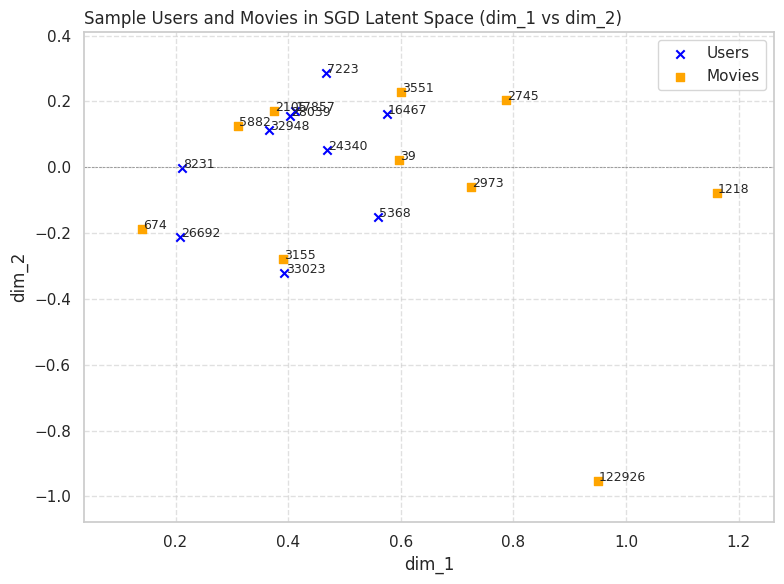

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# --- Choose Latent Dimensions ---
dim_1 = 0
dim_2 = 1

# --- Create DataFrames for SGD user and movie latent vectors ---
user_latent_df = pd.DataFrame(best_P[:, [dim_1, dim_2]],
                              index=list(user_map.keys()),
                              columns=['dim_1', 'dim_2'])

movie_latent_df = pd.DataFrame(best_Q[:, [dim_1, dim_2]],
                               index=list(movie_map.keys()),
                               columns=['dim_1', 'dim_2'])

# --- Sample 10 Users and 10 Movies ---
sample_users = user_latent_df.sample(n=10, random_state=42)
sample_movies = movie_latent_df.sample(n=10, random_state=42)

# --- Plot Users and Movies in Latent Space ---
plt.figure(figsize=(8, 6))
plt.scatter(sample_users['dim_1'], sample_users['dim_2'], color='blue', label='Users', marker='x')
for idx, row in sample_users.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

plt.scatter(sample_movies['dim_1'], sample_movies['dim_2'], color='orange', label='Movies', marker='s')
for idx, row in sample_movies.iterrows():
    plt.text(row['dim_1'] + 0.002, row['dim_2'], str(idx), fontsize=9)

# --- Axes and Labels ---
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)

# --- Set dynamic axis limits with padding ---
all_points = pd.concat([sample_users, sample_movies])
x_min, x_max = all_points['dim_1'].min(), all_points['dim_1'].max()
y_min, y_max = all_points['dim_2'].min(), all_points['dim_2'].max()
padding_x = (x_max - x_min) * 0.1
padding_y = (y_max - y_min) * 0.1
plt.xlim(x_min - padding_x, x_max + padding_x)
plt.ylim(y_min - padding_y, y_max + padding_y)

plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.title("Sample Users and Movies in SGD Latent Space (dim_1 vs dim_2)", loc='left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**Comparison of SGD and SVD Latent Spaces**

These plots visualize how a sample of users and movies are positioned in 2D latent space using two matrix factorization methods: **Stochastic Gradient Descent (SGD)** and **Singular Value Decomposition (SVD)**.

* **SGD Plot** (Top):
  Shows more spread and separation among movies (e.g., movie `122926` is distant), suggesting stronger gradients in user preferences. Closer user-movie pairs (e.g., user `58822` near multiple movies) imply better personalization in some cases.

* **SVD Plot** (Bottom):
  Features a much tighter clustering near the origin, implying denser overlap in latent preferences. This may reflect broader generalization or lower dimensional variance, which could benefit cold-start scenarios but reduce nuance in personalized recommendations.

In summary, **SGD** emphasizes stronger user-specific separation, while **SVD** exhibits more compact general structure.


#### ***Step 5.2: Visualization of User Top Movie Matches in SGD Latent Space***

This plot maps 10 randomly selected users (blue) and their top unseen movie recommendations (orange) in a 2D latent space generated by Stochastic Gradient Descent (SGD) matrix factorization.

Each green dashed line connects a user to the movie with the highest predicted score among their unrated items.

Key highlights:

* User and movie embeddings are derived from SGD-learned latent factors.
* Proximity in space reflects alignment in latent preferences.
* Connections visualize how personalized the top recommendation is for each user.

This helps diagnose whether the learned space captures nuanced user-movie affinities.


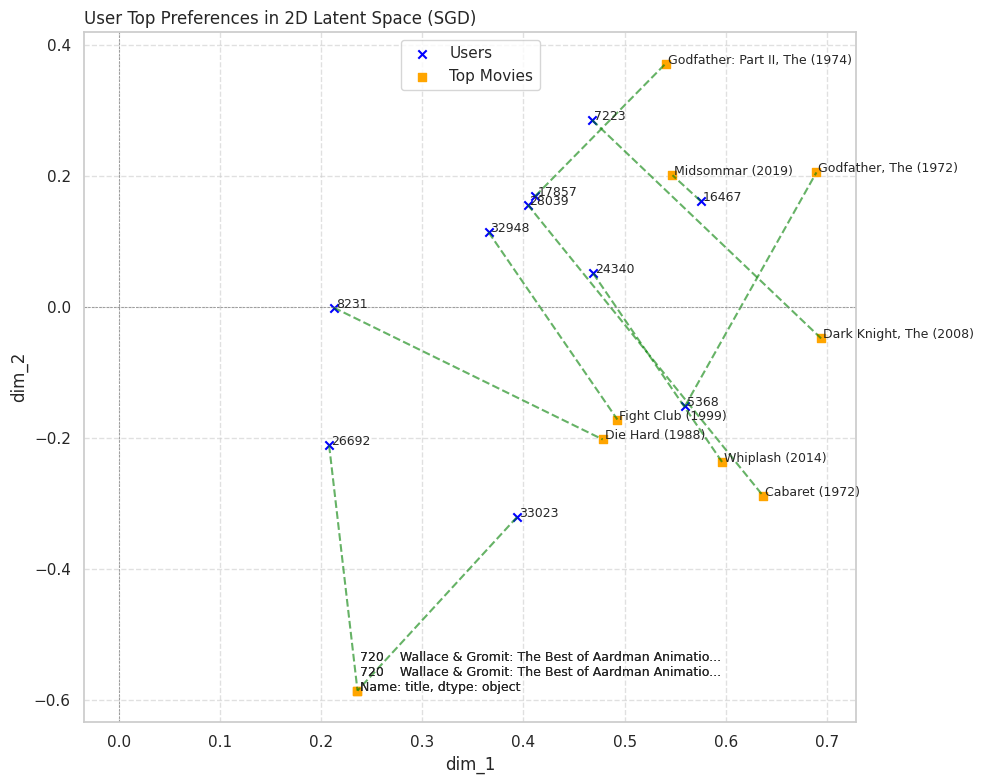

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Set Latent Dimensions to Plot
dim_1 = 0
dim_2 = 1

# Step 2: Build User and Movie Latent DataFrames
user_latent_df = pd.DataFrame(best_P[:, [dim_1, dim_2]],
                              index=list(user_map.keys()),
                              columns=["dim_1", "dim_2"])

movie_latent_df = pd.DataFrame(best_Q[:, [dim_1, dim_2]],
                               index=list(movie_map.keys()),
                               columns=["dim_1", "dim_2"])

# Step 3: Pick Sample Users
sample_user_ids = np.random.choice(list(user_map.keys()), size=10, replace=False)
sample_users = user_latent_df.loc[sample_user_ids]

# Step 4: Get Top Movies for Each Sample User
top_movie_ids = []
top_movie_titles = []
user_coords = []
movie_coords = []

for uid in sample_user_ids:
    uidx = user_map[uid]
    user_vector = best_P[uidx]
    scores = np.dot(user_vector, best_Q.T)

    rated = train_ratings[train_ratings['userId'] == uid]['movieId'].tolist()
    unseen_scores = {mid: score for mid, score in zip(movie_map.keys(), scores) if mid not in rated}
    if not unseen_scores:
        continue

    best_movie_id = max(unseen_scores, key=unseen_scores.get)
    top_movie_ids.append(best_movie_id)
    top_movie_titles.append(movies.loc[movies['movieId'] == best_movie_id, 'title'].values[0])
    user_coords.append(user_latent_df.loc[uid])
    movie_coords.append(movie_latent_df.loc[best_movie_id])

# Convert to DataFrames
top_movies_df = pd.DataFrame(movie_coords, index=top_movie_ids, columns=["dim_1", "dim_2"])
top_movies_df["title"] = top_movie_titles
users_df = pd.DataFrame(user_coords, index=sample_user_ids, columns=["dim_1", "dim_2"])

# Step 5: Plot
plt.figure(figsize=(10, 8))

# Users
plt.scatter(users_df["dim_1"], users_df["dim_2"], color="blue", label="Users", marker="x")
for idx, row in users_df.iterrows():
    plt.text(row["dim_1"] + 0.002, row["dim_2"], str(idx), fontsize=9)

# Movies
plt.scatter(top_movies_df["dim_1"], top_movies_df["dim_2"], color="orange", label="Top Movies", marker="s")
for idx, row in top_movies_df.iterrows():
    plt.text(row["dim_1"] + 0.002, row["dim_2"], top_movies_df.loc[idx, "title"], fontsize=9)

# Connections
for u_row, m_row in zip(users_df.values, top_movies_df[["dim_1", "dim_2"]].values):
    plt.plot([u_row[0], m_row[0]], [u_row[1], m_row[1]], linestyle='--', color='green', alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("dim_1")
plt.ylabel("dim_2")
plt.title("User Top Preferences in 2D Latent Space (SGD)", loc='left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


**Comparison of SVD vs SGD User-Movie Latent Space Preferences**

These two plots contrast user top movie preferences projected into 2D latent space using **SVD** and **SGD-based matrix factorization**.

**1. Spatial Compression vs Spread**

* **SVD** shows users and movies clustered tightly near the origin, reflecting compact latent structure with small magnitudes—common when using truncated SVD on normalized matrices.
* **SGD** produces a more dispersed layout, allowing greater differentiation between user preferences and movie characteristics.

**2. Movie Diversity**

* **SGD** recommendations span a broader thematic range—from *Midsommar* to *Wallace & Gromit*—suggesting more expressive latent embeddings.
* **SVD** recommendations, while solid, tend toward highly rated classics like *Godfather*, *Snatch*, or *RoboCop*, possibly due to stronger global patterns but less personalized variance.

**3. Alignment and Proximity**

* Both models achieve close user-movie pairings in some cases, but **SGD** appears to capture finer-grained distinctions, especially for users with niche interests (e.g., *Cabaret*, *Whiplash*).
* **SVD** excels at recommending generally well-received movies but may miss subtle user-specific cues.

**Conclusion:**
SVD offers stability and interpretability with global patterns, while SGD captures more individualized, expressive preferences with greater spatial diversity. The choice depends on whether the goal is general robustness (SVD) or nuanced personalization (SGD).


#### ***Step 5.3: Visualizing User Embeddings: Why Clustering and Dimensionality Reduction Matter in Recommender Systems***

This analysis is essential for interpreting and validating **matrix factorization-based recommender systems**.

Matrix factorization models (like SVD or ALS) produce dense **latent embeddings** for users and items, capturing hidden preference patterns. To make sense of these:

* **Standardization** ensures fair comparison across dimensions.
* **K-Means Clustering** groups users with similar latent traits.
* **PCA and t-SNE** reduce high-dimensional embeddings to 2D for visualization.

By faceting PCA and t-SNE plots, we reveal user clusters and structure:

* Tight, well-separated clusters suggest clear preference segments.
* Overlapping or diffuse clusters may point to noise or generalist users.

This process confirms that the model is learning meaningful user profiles, enabling **targeted personalization** and surfacing **potential improvements** in the recommendation engine.


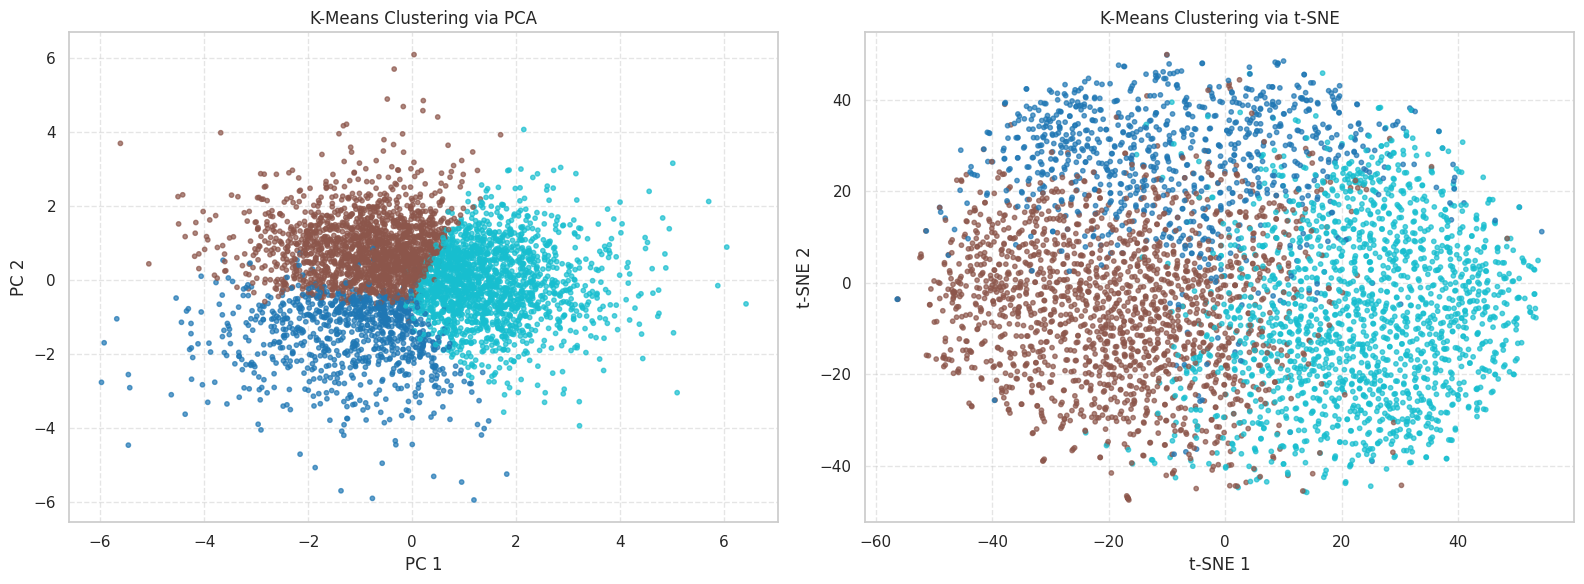

In [143]:
# --- Required Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# --- Step 1: Standardize User Embeddings ---
scaler = StandardScaler()
P_scaled = scaler.fit_transform(P)  # P is your user latent matrix

# --- Step 2: Apply KMeans Clustering ---
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
user_clusters = kmeans.fit_predict(P_scaled)

# --- Step 3: Dimensionality Reduction ---
# PCA
pca = PCA(n_components=2)
P_2d = pca.fit_transform(P_scaled)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
P_tsne = tsne.fit_transform(P_scaled)

# --- Step 4: Faceted Plot of PCA and t-SNE ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA Plot
axes[0].scatter(P_2d[:, 0], P_2d[:, 1], c=user_clusters, cmap='tab10', s=10, alpha=0.7)
axes[0].set_title("K-Means Clustering via PCA")
axes[0].set_xlabel("PC 1")
axes[0].set_ylabel("PC 2")
axes[0].grid(True, linestyle='--', alpha=0.5)

# t-SNE Plot
axes[1].scatter(P_tsne[:, 0], P_tsne[:, 1], c=user_clusters, cmap='tab10', s=10, alpha=0.7)
axes[1].set_title("K-Means Clustering via t-SNE")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### Insight from Faceted Clustering Plots (PCA vs. t-SNE)

These side-by-side visualizations help us evaluate the structure and separability of user clusters derived from matrix factorization embeddings.

* **Left (PCA)**: The clusters are moderately separated, but some overlap exists near the center. PCA, being linear, may not fully capture complex, nonlinear relationships among user latent features.

* **Right (t-SNE)**: Clusters appear more distinct with clearer boundaries. t-SNE preserves local structure and reveals nuanced groupings that PCA may flatten. However, t-SNE is more sensitive to parameter tuning.

**Key Insight**:
The presence of visible clustering in both PCA and t-SNE projections confirms that the latent user matrix (from matrix factorization) encodes meaningful preference patterns. This supports the quality of the learned embeddings and validates the foundation for personalized recommendations. If clustering were weak or noisy, it might signal insufficient training, too few latent factors, or poor regularization.


### **References:**

* **Simon Funk's SVD Approach in the Netflix Prize**
  Funk introduced truncated SVD to collaborative filtering, often using $k = 100$ or fewer latent factors to capture essential user-item interactions.
  Reference: Simon Funk’s blog – [http://sifter.org/\~simon/journal/20061211.html](http://sifter.org/~simon/journal/20061211.html)

* **Matrix Factorization Techniques for Recommender Systems**
  Yehuda Koren, Robert Bell, and Chris Volinsky (2009)
  This foundational paper suggests using $k$ in the range of 20–100 depending on dataset sparsity and size.
  Available at: [https://www.researchgate.net/publication/220722314\_Matrix\_Factorization\_Techniques\_for\_Recommender\_Systems](https://www.researchgate.net/publication/220722314_Matrix_Factorization_Techniques_for_Recommender_Systems)

These sources align with practical findings: for typical recommender datasets (e.g. MovieLens), **k = 60–100** is usually sufficient to capture key user–item interactions without overfitting or incurring heavy computational costs.
